In [143]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import torch 
from torchvision import transforms, utils
from torch.utils.data import Dataset
from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten

In [132]:
def get_lat_lon(rel_path_to_images):
    """
    Extracts lat and lon from image name and store them in array
    !! Co-ordinates are saved as [Lon, Lat] !!
    """

    # get list of all filenames (insert path as string)
    file_names = os.listdir(rel_path_to_images)

    # strip everything but the coordinates and split lattitude and longitude
    coord = [i[4:-4] for i in file_names]

    # split to get lat and long and change type to np array 
    labels = np.array([np.array(i.split(","), dtype = float) for i in coord])
    
    return labels

In [133]:
#ToDo: Find optimal k (use Elbow Method?)
# Different outputs here because i was playing around with formats for the dataloader and thought
# we could eventually use those later

def get_clusters(labels, k):

    """
    Create k clusters and assign a cluster to each sample
        
        Returns:
        labels = array shape N*3 of sample co-ordinates with their respective cluster
        label_location: Dict that contains the center co-ordinates of each cluster
        
    """
    
    x, y = kmeans2(labels, k, iter = 20)  
    labels = np.hstack((labels, y[:, np.newaxis]))
    
    # create dict to map class to co-ordinates for final prediction
    keys = np.arange(len(x))
    label_location = {keys[i]:x[i] for i in range(len(x))}
    
    return labels, label_location, y

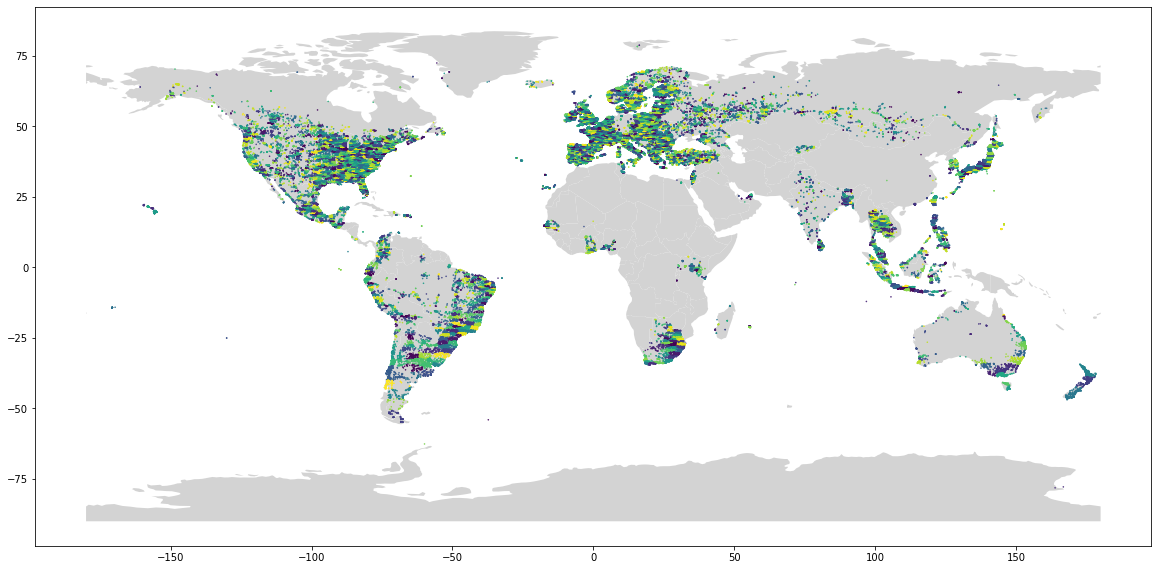

In [64]:
# nice plot for presentation

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
lab_for_plot = labels.copy()

countries.plot(color="lightgrey", figsize = (20, 16))


plt.scatter(labels[:,1], labels[:,0], c=y, s = 0.3)
plt.show()

In [63]:
# Roadmap
# Determine optimal number of classes with Elbow method
# store the position of each centroid
# In NN classify probability of sample belonging to a cluster
# use probabilities to compute predicted location by weighting the coordinates of centroids

# ToDo
# Elbow Method




In [144]:
# create Dataloader
# in the NN we would only predict classes, not yet coordinates. This allows y to be one number per sample
# This can later be changed, just seemed more convenient to me

class GeoGuessrData(Dataset):
    
    def __init__(self, y, root_dir, transform = None):
        """
        y(array): array shape N with clusternames
        root_dir(string): Directory with all the images
        transform: As we won´t need to resize anything we just transform array-->tensor
        """
        self.y = y
        self.root_dir = root_dir
        self.transform = transform
        
    def __getitem__(self, idx):
        """support the indexing such that dataset[i] can be used to get ith sample"""
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get image by path and idx
        img_name = os.listdir(self.root_dir)[idx]
        image = io.imread(os.path.join(self.root_dir, img_name))
        sample = {"image": image, "cluster": y[idx]}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        
    
    def __len__(self):
        
        # get len of dataset
        return len(self.y)
    
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, cluster = sample['image'], sample['cluster']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        
        # not 100% sure if transforming y is of any use yet
        return {'image': torch.from_numpy(image),
                'cluster': torch.from_numpy(np.array(cluster))}

In [ ]:
# load dataset for dataloader
labels = get_lat_lon("Projekt")
labels, label_location, y = get_clusters(labels, 20000)
dataset = GeoGuessrData(y, "Projekt", ToTensor())

# just a test (why does this work?? didn´t even specify an index or call the __getitem__ function )
for i in range(5):
    sample = dataset[i]
    print(i, sample['image'].shape, sample['cluster'])

In [154]:
# it somehow breaks when i try to set the num_workers argument. Idk why
dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 2, shuffle = True)
data = iter(dataloader)
data = data.next()
images, cluster = data['image'].shape, data['cluster']
print(images, cluster)

(torch.Size([2, 3, 512, 2560]), tensor([4647, 4029], dtype=torch.int32))